## Stock Sentiment Analyzer

This is our team's sentiment analyzer. It aims to identify the sentiment behind groups of tweets from twitter in real time. 

We used this tutorial as a reference while creating our model: resource/tutorial used:
- https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

We also referenced other tutorials to find which one would work best for our usecase.
- https://realpython.com/sentiment-analysis-python/?fbclid=IwAR1sO-Zz3j9DQ9NdYiAciQIDTshzpqP_hxzPH-RjomOzlioXZeZjy_XDusE


In [1]:
import pandas as pd
import spacy as sp
from spacy.util import minibatch, compounding
import os
import random
import string
import json
from twython import Twython
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_colwidth', -1)

In [2]:
#read from stock kaggle dataset
stock_df = pd.read_csv('stock_data.csv')
stock_df.head()

,Text,Sentiment
0,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",1
1,user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,1
2,user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [3]:
punctuations = string.punctuation


nlp = sp.load('en_core_web_sm')
stop_words = sp.lang.en.stop_words.STOP_WORDS


parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    #take out punctuation as well as per the library (it doesn't want punctuation)
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
    return text.strip().lower()

bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

X = stock_df['Text'] 
ylabels = stock_df['Sentiment'] 

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)


In [4]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x1a1a7bf2e8>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 tok...)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x1a1990a378>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
             

In [5]:
from sklearn import metrics
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print('Logistic Regression F1:', metrics.f1_score(y_test, predicted))

Logistic Regression Accuracy: 0.7894131185270425
Logistic Regression Precision: 0.7978458989229494
Logistic Regression Recall: 0.8875576036866359
Logistic Regression F1: 0.8403141361256543


In [6]:
# Load credentials from json file
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

# Instantiate Twython object
python_tweets = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])

In [7]:
# Search tweets
def search_twitter(ticker):
    # Create our query
    query = {'q': ticker,
        'result_type': 'recent',
        'count': 10,
        'lang': 'en',
        }
    tweets = []
    for status in python_tweets.search(**query)['statuses']:
        tweets.append(status['text'])
    return pd.Series(tweets)

In [8]:
def find_predictions(tweets):
    predicted = pipe.predict(tweets)
    return predicted

In [9]:
def display_split(predicted, ticker):
    neg = len(predicted[predicted == -1])
    pos = len(predicted[predicted == 1])

    labels = 'Positive', 'Negative'
    sizes = [pos, neg]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  
    title = "Sentiment Split of " + ticker
    ax1.set_title(title)
    plt.show()

0    $TSLA biggest competitive threat is Apple with Volkswagon and GM being remotely competitive https://t.co/AZgT4QIHSd                                           
1    RT @JohnnaCrider1: Listening to Don’t Doubt ur vibe by @elonmusk as we enter GA 400 and it’s EMPTY #TeslaParade @nickwhoward  @Tesla @Tesla…                  
2    Buying Nasdaq Next Gen 100: The 'Smaller' Nasdaq ETF $QQQJ Also $AAPL $ADBE $TSLA https://t.co/CI81lEnsfR                                                     
3    @alifarhat79 Looks like a $TSLA shareholder                                                                                                                   
4    @ElectronComm @PhenomenalPoto @lorakolodny @TheOnion @matthewstoller @kenklippenstein care to weigh in? $TSLA just… https://t.co/EFozqCxTg1                   
5    RT @GretaMusk: Second richest man in the world "encouraging" his employees to "volunteer" is totally legal, right @RBReich? #Tesla $TSLA $T…                  
6    @BergiusPet

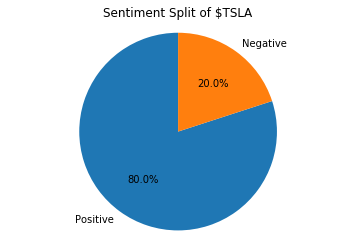

In [10]:
# user interaction to find ticker information

ticker = '$TSLA' #input $ticker as a string
tweets = search_twitter(ticker)
print(tweets)
predictions = []
if (tweets.size == 0):
    print("There are no tweets about this company!")
else:
    predictions = find_predictions(tweets)
    display_split(predictions, ticker)

In [13]:
ground_truths = [-1, 1, 1, 1, -1, -1, 1, 1, -1, 1]

print("Test Accuracy:",metrics.accuracy_score(ground_truths, predictions))
print("Test Precision:",metrics.precision_score(ground_truths, predictions))
print("Test Recall:",metrics.recall_score(ground_truths, predictions))
print('Test F1:', metrics.f1_score(ground_truths, predictions))

Test Accuracy: 0.6
Test Precision: 0.625
Test Recall: 0.8333333333333334
Test F1: 0.7142857142857143
